# Analyzing SAT scores and Overall Demographics
The SAT test plays a very important role in which colleges a prospective student may be admitted to. Therefore, if we analyze how certain demographics play a role in the overall SAT score, we can potentially determine the "fairness" of the test.  New York has a very large and extremely diverse population and would be a great place to investigate this further.  We will be working with Data from New York Public Schools and will try to find potential correlations with demographics and the students SAT test score.  These can include demographics such as race, income, gender, etc.

We'll be working with multiple different datasets that we will combine into one master dataframe.  The datasets are as following:
- SAT scores by school
- School attendance
- Class Size
- AP test results
- Graduation outcomes
- Demographics
- School survey

# Read in the data
We'll begin by importing the necessary libraries and reading in the data.  We can run a loop through the file names and add all the datasets into a dictionary.  We'll next need to clean them before eventually joining them all.

The surveys are in txt format, so we'll need to read that data in separately.  We also need to do some quick cleaning to fix the <code>'DBN'</code> column to match the rest of the datasets.  We only need a handful of columns from the surveys, so we'll chose only those that are important for our analysis.

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]

data = {}

for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d

In [2]:
#Read in both surveys into separate dataframes and then concantante them.
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey['DBN'] = survey['dbn']

survey_fields = [
    'DBN', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]
survey = survey.loc[:,survey_fields]
#Add the survery dataset to the dictionary
data['survey'] = survey

Knowing that the <code>'DBN'</code> relates to a schools location, this may be a column that will require some cleaning amongst datasets.  Let's take a look at a couple examples.

In [3]:
data['hs_directory']['dbn'].head()

0    17K548
1    09X543
2    09X327
3    02M280
4    28Q680
Name: dbn, dtype: object

In [4]:
data['class_size'].head(2)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN


# Add DBN columns
The class_size dataset does not have a DBN column at all.  Instead it has multiple columns that represent parts of the DBN code.  The DBN code looks like '17K548', so we'll need to combine multiple columns to create the DBN for class_size.

We can accomplish this by creating a function that returns the CSD if it's two digits, if it's just one, we'll need to add the 0 to match DBN.

In [5]:
#Rename DBN column in hs_directory
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation

#Apply the function and then create the DBN column adding the padded_csd with school code.
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Convert columns to numeric
To succesfully analyze the SAT scores, we'll need to convert them into numbers.  Right now they're just objects.  We can easily do this by looping through the column names and converting each column to numeric format.  

After we do that, we can combine all the different SAT scores (Math, Verbal, and Writing) into one total SAT score.

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

Part of our analysis is focusing on the actual location of these schools so we can compare geographically.  We'll need to parse the Location column and extract out Latitute and Longitute coordinates.  We can do this by creating functions and applying them to the dataset.

In [7]:
def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat

def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

#Convert to numeric
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

# Condense datasets
We're only focusing on High Schools, so we need to reduce the class_size dataset to include only grades 09-12.  The class_size dataset also has multiple values for each DBN in core subject (English, Math, etc.) and different classes.  We'll want to find the mean of class sizes for each DBN.

In the demographics dataset, we'll want to filter based on the most recent year of 2011-2012.  Unfortunatley for the graduation dataset, the most recent year is 2006, so we'll filter based on that.

In [8]:
#Filter by 09-12 grades and filter by the General Education category.
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

#Find the mean of class sizes for each school and reset the index.
class_size = class_size.groupby('DBN').agg(numpy.mean)
class_size.reset_index(inplace=True)
#Place the updated dataset back into the dictionary
data['class_size'] = class_size

#Filter based on the most recent year in the dataset which is 20112012
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

#The most recent year in the graduation dataset is 2006 so we'll filter on that with demographic being total cohort.
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

# Convert AP scores to numeric
The AP scores need to be converted to numeric as well and we can accomplish this the same way as before with the SAT scores.

In [9]:
#Loop through the column names and convert each one to numeric values.
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

# Combine the datasets
Finally we can begin merging the datasets on the DBN code.  This way all the different datasets will be added to each school code.

Since we want to keep as much SAT data as possible.  We'll begin with that dataset to reduce data loss.  We can use a left join so we don't lose any SAT rows.  We'll end up with some NaN values in the rows that don't exist however.

Once we begin merging the demographics related data, we'll switch to an inner join to reduce data loss from these datasets.

As mentioned above, we will be left with a lot of NaN values and will need to clean those.  We can take the overall mean of the columns and replace the NaN values with the means.  This unfortunatley is not the most accurate way to handle the data, but it will help when we run correlations for our analysis.

In [10]:
#left joins
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

#inner joins
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']
for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')

#fill NaN values with means
combined = combined.fillna(combined.mean())

#Any column that doesn't allow mean, we'll add a zero.
combined = combined.fillna(0)

# Add a school district column for mapping
We're very intersted in the location of the schools, so we can create a new column that has just the school district of the DBN code.  That is the first two characters.

In [11]:
#Create the function to extract the first two characters and apply it to DBN to create the school district.
def get_first_two_chars(dbn):
    return dbn[0:2]

combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)

# Find correlations
Running correlations can help us find any categories that heavily influence one another.  Since we're looking for what possible columns affect SAT score, we can run the correlations on SAT score.  Any values that are close to 1 correlate strongly.

In [12]:
correlations = combined.corr()
correlations = correlations['sat_score']
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


Of course SAT score correlates highly with itself, but we're interested in other columns that may correlate.  It can help to visualize the heatmap of the correlations to look for any potential matches.  

High correlations seem to be with AP test takers, total exams taken, asian_per, white_per, N_s, N_p, saf_t_11, saf_tot_11, female_per, male_per, and aca_tot_11.  These will be good places to start to explore further

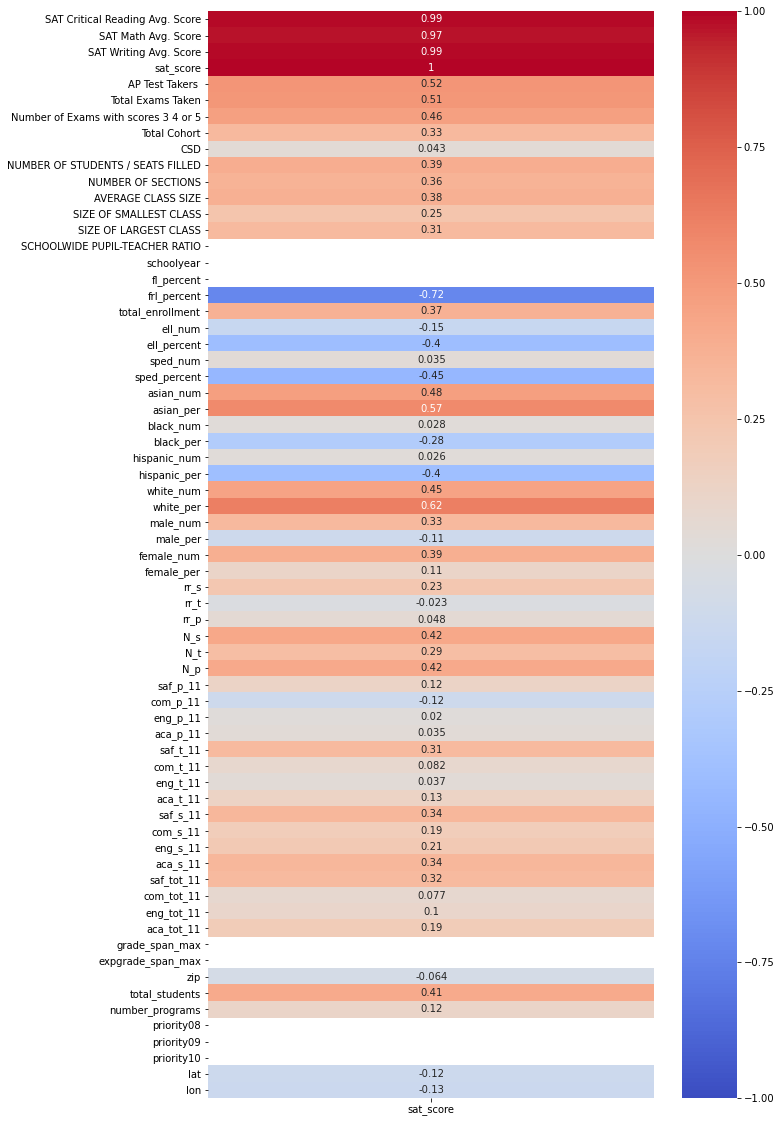

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(pd.DataFrame(correlations),annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax = ax)

# Plotting survey correlations
Above a lot of correlations seem to be coming from the survey.  We can visualize this a bit further by plotting a bar graph with the survey fields.

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove('DBN')

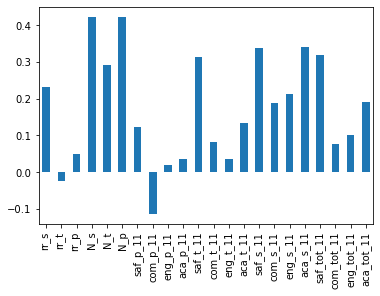

In [15]:
combined.corr()['sat_score'][survey_fields].plot.bar()

- We can see there is high correlation with N_s, N_t, and N_p.  These columns are based on the total number of respondents to the survey, so it would make sense that it's linked highly with total enrollment. 

- Another area of strong correlation are the saf_s, saf_t, and saf_tot columns.  This makes sense because typically safer schools might have students that take education more seriously and possibly a higher caliber of teachers since they wouldn't be worried about their own saftey.

- Another correlation is with rr_s.  This is the student response rate.  This could mean that the students who responded to the survey are also students who study more and take education more seriously.

- Lastly, there is a correlation with aca_s_11, but not aca_p_11 and aca_t_11.  These columns relate to how the one taking the survey perceives academic standard.  This is interesting because only the students in this category correlate with SAT scores

# Scatter Plot of Safety

Safety seems to be a reason for differences in SAT Scores.  Let's begin researching this section with a scatter plot

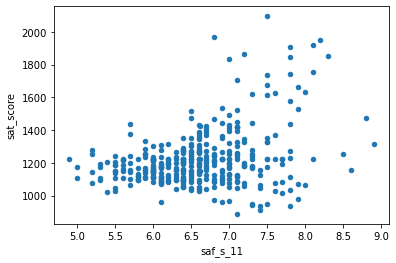

In [16]:
combined.plot.scatter('saf_s_11','sat_score')

Looking at the scatter plot, there is a larger concentration of lower SAT scores when the Safety Score is lower.  This makes sense.

# Explore Boro Safety with Grouping and Pivot Tables
We can aggregate the data using averages to explore the safety and see if it's only certain areas that are affected.

We can group the dataset by Borough and see what the average sat score and safety score is.

In [17]:
boro_safety = combined.groupby('boro').agg(numpy.mean)[['saf_s_11','sat_score']]
boro_safety

,saf_s_11,sat_score
boro,,
Bronx,6.606577,1157.598203
Brooklyn,6.370755,1181.364461
Manhattan,6.831370,1278.331410
Queens,6.721875,1286.753032
Staten Island,6.530000,1382.500000


Looking at the safety score with sat score per boro, it does for the most part follow the trend that the lower the safety the lower the sat score.  The one outlier seems to be Staten Island, which has a lower Safety Score then the Bronx, however they have the highest SAT score average.

We can create a pivot table on races for each boro to see if this might explain Staten Island.

In [18]:
boro_pivot = combined.pivot_table(values = ['white_per','asian_per','black_per','hispanic_per'], index = 'boro', aggfunc= 'mean')
boro_pivot

,asian_per,black_per,hispanic_per,white_per
boro,,,,
Bronx,3.283871,30.237634,63.169892,2.709677
Brooklyn,7.376415,56.233962,28.701887,7.037736
Manhattan,10.878889,26.634444,52.272222,9.127778
Queens,23.670313,30.064062,33.646875,11.757812
Staten Island,10.300000,18.270000,22.170000,48.810000


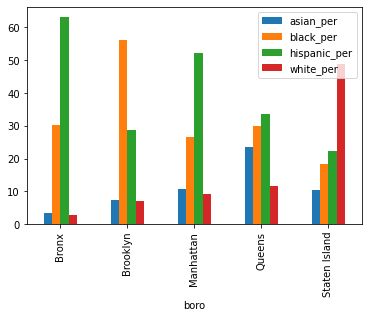

In [19]:
boro_plot = boro_pivot.plot.bar()

It seems that Staten Island has a very high White population.  This could be an explanation for the higher score.  Let's dive a bit deeper into racial differences with the SAT scores.

# Racial Differances
We saw earlier that there were high correlations with race and we also saw that although Staten Island had a lower safety score, they had the highest SAT score.  They also had the highest concentration of white people.

In [20]:
#Make a list of the race columns
races = ['white_per','asian_per','black_per','hispanic_per']

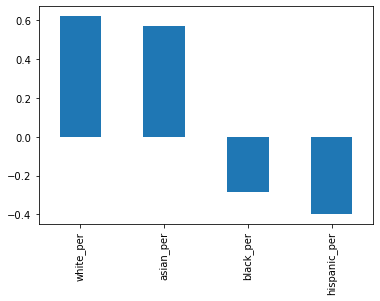

In [21]:
#Visualize the correlation with a bar plot
combined.corr()['sat_score'][races].plot.bar()

Overall it seems that schools with more white and asian people tend do better on the SATs.  The schools with more black and hispanic people tend to do worse.  We should investigage to see why (lack of funding, safety, etc.).  Hispanics seemed to have the highest negative correlation so let's begin looking at potential reasons why.

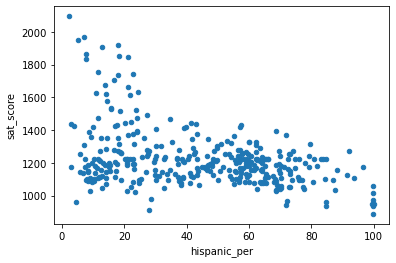

In [22]:
combined.plot.scatter('hispanic_per', 'sat_score')

The higher the percentage of Hispanic students there are, the lower the SAT scores.

# Filtering the Dataset by Hispanic population
We can take a deeper look at this by filtering on the dataset schools that have higher percentages of Hispanic students.  Let's look at the school names for schools with 95% or more Hispanics.

In [23]:
print(combined[combined['hispanic_per'] >= 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Looking at the names, it seems that most of these schools are International program schools.   This would help explain lower SAT scores as these are schools full of students who are just beginning to learn english.

Now let's take a look at the school names for schools that have 10% or less Hispanics and an average SAT score of 1800 or more.

In [24]:
print(combined[(combined['hispanic_per'] <= 10) & (combined['sat_score'] >= 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools look like technical or science schools that will be geared more towards higher education.  More than likely, to even get into these schools, one would have to pass an entrance exam.

# Gender Differences
There were correlations earlier with gender and SAT scores.  Let's take a look at that.

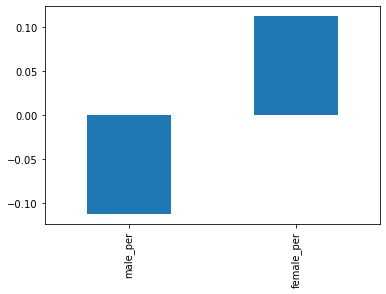

In [25]:
genders = ['male_per', 'female_per']
combined.corr()['sat_score'][genders].plot.bar()

Surprisngly, schools with more Males negatively correlate and with more Females there is a positive correlation.

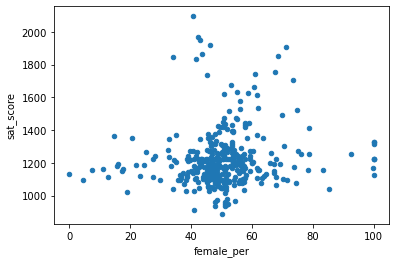

In [26]:
combined.plot.scatter('female_per','sat_score')

Doesn't seem to be much correlation.  Let's investigate further.  We can filter the dataset on schools that have 60% or more females and an SAT score of 1700 and up.

In [27]:
print(combined[(combined['female_per'] >= 60) & (combined['sat_score'] >= 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These seem to be some very selective schools with a focus on higher education.

# Schools with more AP Test Takers
Another correlation was with AP Test takers.  This would make sense as typically the students who score higher on Advance Placement tests would take education more seriously.  They could be focusing on getting into College and would want to do well on the SAT's.

We can try to visualize this further by creating a new column that is the ratio of AP test takers compared to total enrollment.

In [28]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

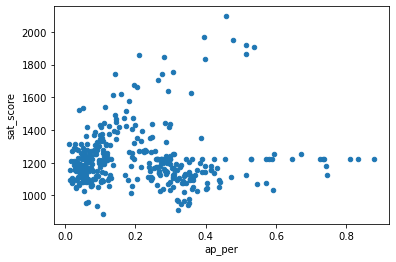

In [29]:
combined.plot.scatter('ap_per','sat_score')

Surprisngly, there is only a small amount of a correlation of AP test takers and higher SAT scores.

# Class Size
We saw ealier that there was also a correaltion with class size.  Let's take a look further.

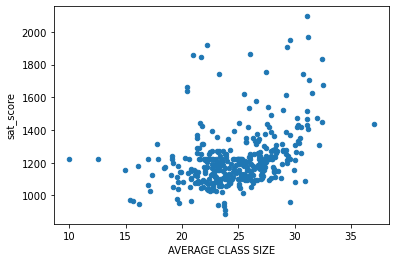

In [30]:
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')

There definitely seems to be correlation as the larger the class size becomes, the higher the total SAT score is.

# Choosing the best school district
We've seen that safety, average class size, and of course the SAT score could represent a good school.  Let's find the best school district and see what the school names are.  

We can accomplish this by grouping the school district's by the means of the columns for SAT score, class size, and safety.

In [31]:
school_dist = combined.groupby('school_dist').agg(numpy.mean)[['sat_score','AVERAGE CLASS SIZE','saf_s_11']]
school_dist.sort_values(by = 'sat_score',ascending = False)

,sat_score,AVERAGE CLASS SIZE,saf_s_11
school_dist,,,
22,1450.500000,30.077636,7.025000
31,1382.500000,28.119729,6.530000
26,1377.600000,29.971140,6.760000
25,1357.000000,27.106270,6.912500
01,1354.500000,22.675415,6.768611
28,1347.846947,26.770807,6.627273
30,1326.382090,25.715644,7.033333
02,1295.638184,25.038118,6.910660
03,1293.443035,23.716311,6.716667


Schools from school district 22 had the highest average SAT score. This district also has large class size's and safety above the score of 7.

Let's filter the data for school district 22 and see where these schools are located.

In [32]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
combined[combined['school_dist'] == '22']

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
276,22K405,MIDWOOD HIGH SCHOOL,824,478.0,519.0,476.0,1473.0,MIDWOOD HS,745.000000,1223.000000,758.00,Total Cohort,MIDWOOD HIGH SCHOOL,2006,872.0,757,86.8%,709,81.3%,93.7%,492,56.4%,65%,217,24.9%,28.7%,48,5.5%,6.3%,97,11.1%,14,1.6%,22,914.473684,28.263158,31.963158,22.421053,34.421053,0.0,MIDWOOD HIGH SCHOOL,20112012,0.0,41.2,3842,,,,,,,,,,,930,1097,914,901,141.0,3.7,198.0,5.2,79,68,1216,31.7,1352,35.2,449,11.7,813,21.2,1739.0,45.3,2103.0,54.7,85.0,95,75,3330.0,178.0,2804.0,7.4,6.5,6.9,7.2,7.4,7.1,7.3,7.8,6.5,5.4,6.2,7.1,7.1,6.3,6.8,7.4,22K405,Midwood High School,Brooklyn,K405,718-724-8500,718-724-8515,9,12,0,12.0,"B103, B11, B41, B44, B44-SBS, B49, B6, B8, Q35","2, 5 to Brooklyn College - Flatbush Ave",2839 Bedford Avenue,Brooklyn,NY,11210,www.midwoodhighschool.org,3877.0,0,0,Midwood High School celebrates a long traditio...,Students may receive CTE endorsement in Engine...,"French, Latin, Spanish","Biology, Calculus AB, Calculus BC, Chemistry, ...",0,0,"Archon, Argus, Arista, Art, BioMed Society, Ch...","Baseball & JV Baseball, Basketball & JV Basket...","Basketball & JV Basketball, Bowling, Cross Cou...",0,"Aerobics, Basketball, Billiards, Bowling, Voll...",0,0,Brooklyn College,Museum of Modern Art (MoMA),0,0,0,0,We are a multi-session school,0,8:45 AM,3:30 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,4,Open to New York City residents,For K26H: Open only to students who reside in ...,For K26L only: Open only to students whose hom...,0,0,0,0,0.0,0.0,0.0,"2839 Bedford Avenue\nBrooklyn, NY 11210\n(40.6...",40.633335,-73.952916,22,0.193909
277,22K425,JAMES MADISON HIGH SCHOOL,518,436.0,475.0,439.0,1350.0,JAMES MADISON HS,323.000000,463.000000,188.00,Total Cohort,JAMES MADISON HIGH SCHOOL,2006,1076.0,713,66.3%,639,59.4%,89.6%,245,22.8%,34.

Although the school district 22 is in Brooklyn which had an overall lower safety score.  These 4 schools seems to be very safe and have high SAT Scores.

# Conclusion
SAT scores have always been used as a strong predictor of college acceptance.  In this project we were able to merge together multiple different datasets to analyze whether or not the test is considered fair.  We've learned that the quality of school is a strong reason as to whether or not the student does well.  The quality of school is determined on overall safety, class size, and school district.  

Race also seems to play an important role, but more than likely this is due to the prevalence of a particular race amongst different locations and boroughs in New York.